## Classification of dog breeds from the Kaggle Dog Breeds dataset.

In [42]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [44]:
# Load labels
labels_df = pd.read_csv('../data/Dog breeds/labels.csv')

# Load and preprocess images
image_dir = "../data/Dog breeds/train/"

In [110]:
labels_df.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Preprocessing

In [45]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(28, 28)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, target_size)  # Resize to target size
    img = img / 255.0  # Normalize pixel values
    img = img.reshape(target_size[0], target_size[1], 1)  # Reshape to match input shape of the model
    return img

In [46]:
# Function to get image path for a given id and folder
def get_image_path(image_id, folder):
    return os.path.join(folder, f"{image_id}.jpg")


In [47]:
# Load images and labels
X_images = []
y_labels = []

for idx, row in labels_df.iterrows():
    image_path = get_image_path(row['id'], image_dir)
    try:
        image = preprocess_image(image_path, target_size=(28, 28))  # Adjust target_size as needed
        X_images.append(image)
        y_labels.append(row.drop('id').values)  # Assuming all columns except 'id' are breed labels
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

In [83]:
# Convert lists to numpy arrays
X_images = np.array(X_images)
y_labels = np.array(y_labels)



In [84]:
print("X_images shape:", X_images.shape)
print("y_labels shape:", y_labels.shape)


X_images shape: (10222, 28, 28, 1)
y_labels shape: (10222, 1)


In [85]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels
y_labels_encoded = label_encoder.fit_transform(y_labels)




c:\Users\sanja\anaconda3\envs\my-env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
from keras.utils import to_categorical

# Convert numerical labels to one-hot encoded format
num_classes = len(label_encoder.classes_)  # Get the number of classes from the label encoder
y_labels_one_hot = to_categorical(y_labels_encoded, num_classes=num_classes)

In [87]:
# Example of train-test split
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels_one_hot, test_size=0.2, random_state=42)

In [88]:
y_labels_one_hot.shape

(10222, 120)

In [89]:
num_classes=120

In [90]:
# Number of classes (dog breeds)
num_classes = y_labels_one_hot.shape[1]  

## Loading the pre-saved CNN model

In [91]:
# Load the saved digits model
cnn = load_model("../models/digit_classifier_cnn.h5")

In [92]:
# Compile the modified model
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to confirm the changes
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

But in this case, I have to change the number of class of my CNN and in the following code I removed the excisting output layer and add a new output layer suitable for this dataset

In [95]:
from keras.layers import Dense

# Define the new number of classes
new_num_classes = 120  

# Remove the existing output layer
cnn.pop()

# Add a new output layer with the new number of classes
cnn.add(Dense(new_num_classes, activation='softmax'))


In [96]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [97]:
cnn.summary

<bound method Model.summary of <Sequential name=sequential, built=True>>

## Model Training

In [98]:
# Train the model
history = cnn.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0126 - loss: 4.8466 - val_accuracy: 0.0238 - val_loss: 4.6787
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0389 - loss: 4.5247 - val_accuracy: 0.0355 - val_loss: 4.5450
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0810 - loss: 4.1904 - val_accuracy: 0.0446 - val_loss: 4.5317
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1450 - loss: 3.8224 - val_accuracy: 0.0391 - val_loss: 4.6883
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2148 - loss: 3.3870 - val_accuracy: 0.0471 - val_loss: 4.8668
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3333 - loss: 2.8476 - val_accuracy: 0.0526 - val_loss: 5.2054
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4448 - loss: 2.3445 - val_accuracy: 0.0520 - val_loss: 5.6822
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5620 - loss: 1.8225 - val_accuracy: 0.

## Model Evaluation

In [100]:
from sklearn.metrics import confusion_matrix, classification_report
# Evaluate the CNN model
y_pred_cnn = cnn.predict(X_test)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_true = np.argmax(y_test, axis=1)

print(confusion_matrix(y_true, y_pred_cnn_classes))
print(classification_report(y_true, y_pred_cnn_classes))

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 1 3 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        22
           2       0.20      0.12      0.15        26
           3       0.04      0.04      0.04        27
           4       0.00      0.00      0.00        12
           5       0.33      0.05      0.09        19
           6       0.00      0.00      0.00        26
           7       0.02      0.05      0.03        20
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00        19
          10       0.10      0.07      0.08        29
          11       0.12      0.12      0.12        26
          12       0.00      0.00      0.00        14
          13       0.09      0.08      0.08        26
          14       0.06      0

c:\Users\sanja\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sanja\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sanja\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


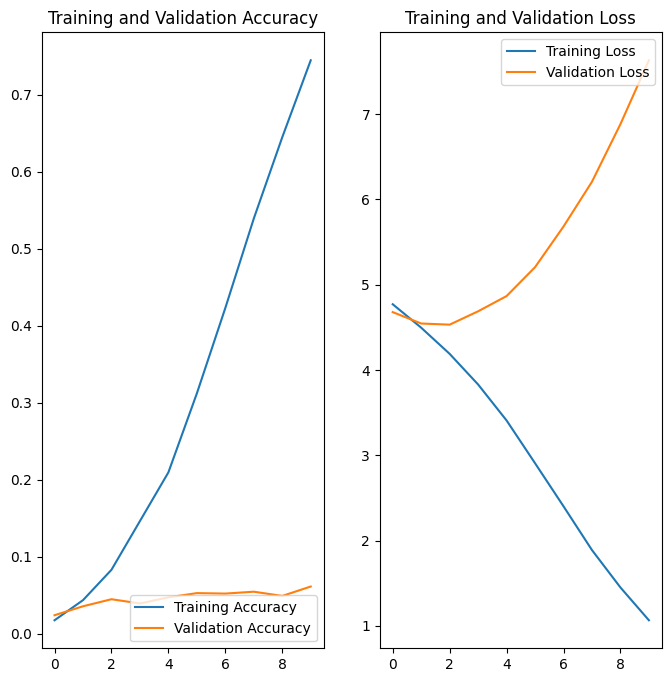

In [107]:
epochs = 10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Validation loss is getting higher and this model is not performing well on this dataset. 

So after this I tried the dataset on a pre-trained CNN.(ResNet50)

In [3]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load labels
labels_df = pd.read_csv('../data/Dog breeds/labels.csv')

# Add file paths to the dataframe
labels_df['file_path'] = labels_df['id'].apply(lambda x: os.path.join("../data/Dog breeds/train/", f"{x}.jpg"))

# Parameters
batch_size = 32
img_size = (224, 224)
num_classes = labels_df['breed'].nunique()

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=None,
    x_col="file_path",
    y_col="breed",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=None,
    x_col="file_path",
    y_col="breed",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Add custom layers on top of the ResNet50 base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the ResNet50 layers to avoid training them
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=callbacks
)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy:.2f}')


Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.
Epoch 1/5


c:\Users\sanja\anaconda3\envs\my-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


256/256 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.2185 - loss: 3.5999 - val_accuracy: 0.6174 - val_loss: 1.3385
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.6984 - loss: 1.0466 - val_accuracy: 0.6820 - val_loss: 1.0859
Epoch 3/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.7631 - loss: 0.7849 - val_accuracy: 0.6888 - val_loss: 1.0366
Epoch 4/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.8084 - loss: 0.6313 - val_accuracy: 0.6903 - val_loss: 1.0401
Epoch 5/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.8364 - loss: 0.5308 - val_accuracy: 0.6967 - val_loss: 1.0101
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6897 - loss: 1.0008
Validation accuracy: 0.69


Observations:
- Initial Validation Accuracy:

The validation accuracy starts at 0.6174 after the first epoch, which indicates that the model quickly learned to make reasonable predictions, possibly due to the effective feature extraction by the pre-trained ResNet50 base model.

- Accuracy Trend:

The validation accuracy increases slightly with each epoch, reaching 0.6967 by the fifth epoch. This indicates a steady improvement, though the rate of increase seems to slow down after the first few epochs.

- Validation Loss:

The validation loss starts at 1.3385 and decreases over the epochs, indicating that the model's predictions are becoming more accurate over time. By the fifth epoch, the validation loss is 1.0101, which shows a consistent improvement.

- Training vs. Validation Accuracy:

The training accuracy increases more rapidly, starting from 0.2185 in the first epoch and reaching 0.8364 by the fifth epoch.